# Regression on the deer data

**Goal:** In this notebook you will work with TFP. You will set up different regression models that are able to output different conditional probability distribution. You will define all models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You compare the performace of all regression models on the test dataset.  


**Usage:** This notebook should be a case study that you can do by yourself. Try to solve the exercises and then look at the solution and compare your results.

**Dataset:** You work with a dataset that describes deer related car accidents in the years 2002 until 2011 on roads in Bavaria, Germany. It counts the number of deers killed during 30-minute periods anywhere in Bavaria. This dataset has been used previously for the analysis of count data in the statistics literature, and is originally from https://zenodo.org/record/17179. 

**Content:**
* Load and split the dataset 
* Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$
* Fit a poisson regression model in keras and TFP
* Fit a poisson regression model with hidden layers in keras and TFP
* Fit a zero-inflated poisson regression model im keras and TFP
* Fit a zero-inflated poisson regression model with hidden layers in keras and TFP
* Fit a mixture model regression model in keras and TFP
* Fit a mixture model regression model with hidden layers in keras and TFP
* Compare the different models based on the NLL loss on the test dataset

***Hint: Use the previous notebooks form this chapter and the one before as help and reference when you try to solve the exercises***  
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb)


In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from typing import *

tfb = tfp.bijectors
tfd = tfp.distributions
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

In [13]:
df_train = pd.read_feather(os.path.join(data_path, "deer_train.feather"))
df_test = pd.read_feather(os.path.join(data_path, "deer_test.feather"))
data = pd.concat([df_train.assign(is_test=0), df_test.assign(is_test=1)], axis=0, ignore_index=True)
print(data.info())
print(data["is_test"].value_counts())
data[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   wild     175296 non-null  int32   
 1   year     175296 non-null  float64 
 2   time     175296 non-null  float64 
 3   daytime  175296 non-null  category
 4   weekday  175296 non-null  category
 5   is_test  175296 non-null  int64   
dtypes: category(2), float64(2), int32(1), int64(1)
memory usage: 5.0 MB
None
0    140256
1     35040
Name: is_test, dtype: int64


,wild,year,time,daytime,weekday,is_test
0,0,2002.0,0.000000,night.am,Sunday,0
1,0,2002.0,0.020833,night.am,Sunday,0
2,0,2002.0,0.041667,night.am,Sunday,0
3,1,2002.0,0.062500,night.am,Sunday,0
4,3,2002.0,0.083333,night.am,Sunday,0


In [14]:
print(data["daytime"].unique())
print(data["weekday"].unique())

['night.am', 'pre.sunrise.am', 'post.sunrise.am', 'day.am', 'day.pm', 'pre.sunset.pm', 'post.sunset.pm', 'night.pm']
Categories (8, object): ['day.am', 'night.am', 'pre.sunrise.am', 'post.sunrise.am', 'day.pm', 'night.pm', 'pre.sunset.pm', 'post.sunset.pm']
['Sunday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [27]:
label = "wild"
features = ["time", "daytime", "weekday"]
train_cond = data["is_test"] == 0

data["time"] /= (df_train["time"].max() + 1 / 48)
data[label] = data[label].astype("float32")

y_train = data.loc[train_cond, label]
y_test = data.loc[~train_cond, label]

X_train = pd.get_dummies(data.loc[train_cond, features])
X_test = pd.get_dummies(data.loc[~train_cond, features])
del data, df_train, df_test

In [29]:
X_train.shape, X_test.shape

((140256, 16), (35040, 16))

Let's look at the distribution of the target variable: the number of deers killed during that 30-minute period. As you can see the distribution is very skewed. Gor most of the time the nummber of deers killed by a car is, as you would expect, zero. On the other hand you can see that there were two 30-minute periods where 37 and 38 deers died! 

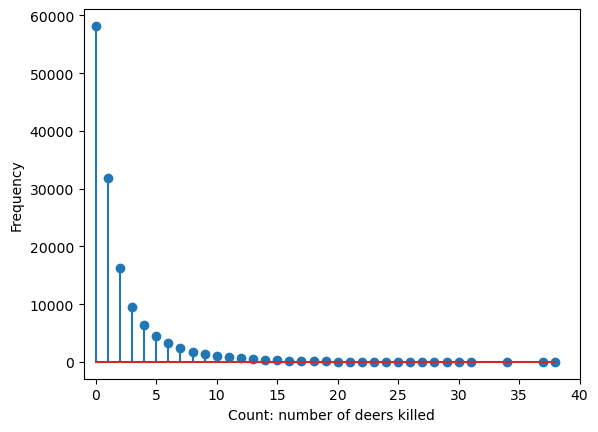

In [30]:
vals, counts = np.unique(y_train, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.show()

### Fitting and comparing different regression models on count data

*Exercise :     
Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$  
Fit a poisson regression model in keras and TFP  
Fit a poisson regression model with hidden layers in keras and TFP  
Fit a zero-inflated poisson regression model im keras and TFP  
Fit a zero-inflated poisson regression model with hidden layers in keras and TFP  
Fit a mixture model regression model in keras and TFP  
Fit a mixture model regression model with hidden layers in keras and TFP*  

*Compare the different models based on the NLL loss on the test dataset*

## Linear regression

In this section you do a standard linear regression in keras and optimize the mean squared error. Afterwards, you can claculate the optimal constant sigma by hand and compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period.

In [38]:
inputs = Input(shape=(X_train.shape[1]))
loc = Dense(1, activation="linear")(inputs)
sigma = tf.keras.layers.Lambda()
out = K.concatenate([loc, sigma], axis=1)
p_y = tfp.layers.DistributionLambda(lambda out: tfd.Normal(loc=out[:, 0], scale=out[:, 1]))(out)
model_lr = Model(inputs=inputs, outputs=p_y)
model_lr.compile(optimizer=Adam(learning_rate=0.01), loss=lambda y_pred, dist: -dist.log_prob(y_pred))
model_lr.summary()

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='tf.zeros_like_3/zeros_like:0', description="created by layer 'tf.zeros_like_3'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.